In [1]:
import os
from pathlib import Path

path = Path(os.curdir).absolute()
if str(path).split("\\")[-1] == "notebooks":
    os.chdir(path.parent)

import tensorflow.compat.v1 as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
import wandb
import segmentation_models_pytorch as smp

from roadtracer.discoverlib import geom
from roadtracer.infer import roadtracer_infer, get_model

from utils.datasets import ImageDataset, np_to_tensor, LargeImageDataset
from utils.utils import *
from models import load_config, model_from_config
from train import train
from trainer import train_smp_wandb
import parameters

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
model1 = smp.EfficientUnetPlusPlus(
    encoder_name='efficientnet-b5',
    encoder_depth=5,
    encoder_weights='imagenet',
    decoder_channels=(256, 128, 64, 32, 16),
    in_channels=3,
    classes=1,
    activation='sigmoid'
)

model1.load_state_dict(torch.load('checkpoints/EfficientUnetPlusPlus_efficientnet-b5_256_1.pth'))
model1.to(DEVICE)
model1.eval()

roadtracer_model, session = get_model()

C:\Users\ArniB\AppData\Local\Temp\ipykernel_11704\2323421658.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('checkpoints/EfficientUne



INFO:tensorflow:Restoring parameters from c:\Users\ArniB\ETH\CIL\CIL-2024\roadtracer\model\model


In [4]:
with torch.no_grad():
    for f in tqdm(sorted(glob(parameters.ROOT_PATH + '/training/images/*.png'))):
        i = int(f[:-4].split('_')[-1])

        image = np.array(Image.open(f), dtype=np.float32)[:, :, :3] / 255.0
        x = np_to_tensor(np.moveaxis(cv2.resize(image, dsize=(384, 384)),-1,0), DEVICE)
        mask_pred = np.moveaxis(model1(x.unsqueeze(0)).detach().cpu().numpy(),1,-1)
        mask_pred = cv2.resize(mask_pred[0], dsize=(400,400))

        im = Image.fromarray(mask_pred * 255).convert('L')
        im.save(parameters.ROOT_PATH + f"/training/predictions/satimage_{i}.png")


  0%|          | 0/144 [00:00<?, ?it/s]

In [17]:
def get_starting_locations(mask, min_prob = 0.99, blocking_dist = 100):
    indices = np.stack(np.unravel_index(np.argsort(mask, axis=None)[::-1], mask.shape), axis=1)
    blocked_locations = np.zeros(mask.shape, dtype=bool)
    starting_indices = []
    for (i0, j0) in indices:
        if mask[i0,j0] < min_prob:
            break

        if not blocked_locations[i0, j0]:
            starting_indices.append(geom.Point(i0 - 200,j0 - 200))
            for i in range(max(0,i0-blocking_dist),min(mask.shape[0],i0+blocking_dist+1)):
                blocking_dist_j = int(np.round(np.sqrt(blocking_dist ** 2 - (i-i0)**2)))
                for j in range(max(0,j0-blocking_dist_j),min(mask.shape[0],j0+blocking_dist_j+1)):
                    blocked_locations[i,j] = True

    return starting_indices

  0%|          | 0/25 [00:00<?, ?it/s]

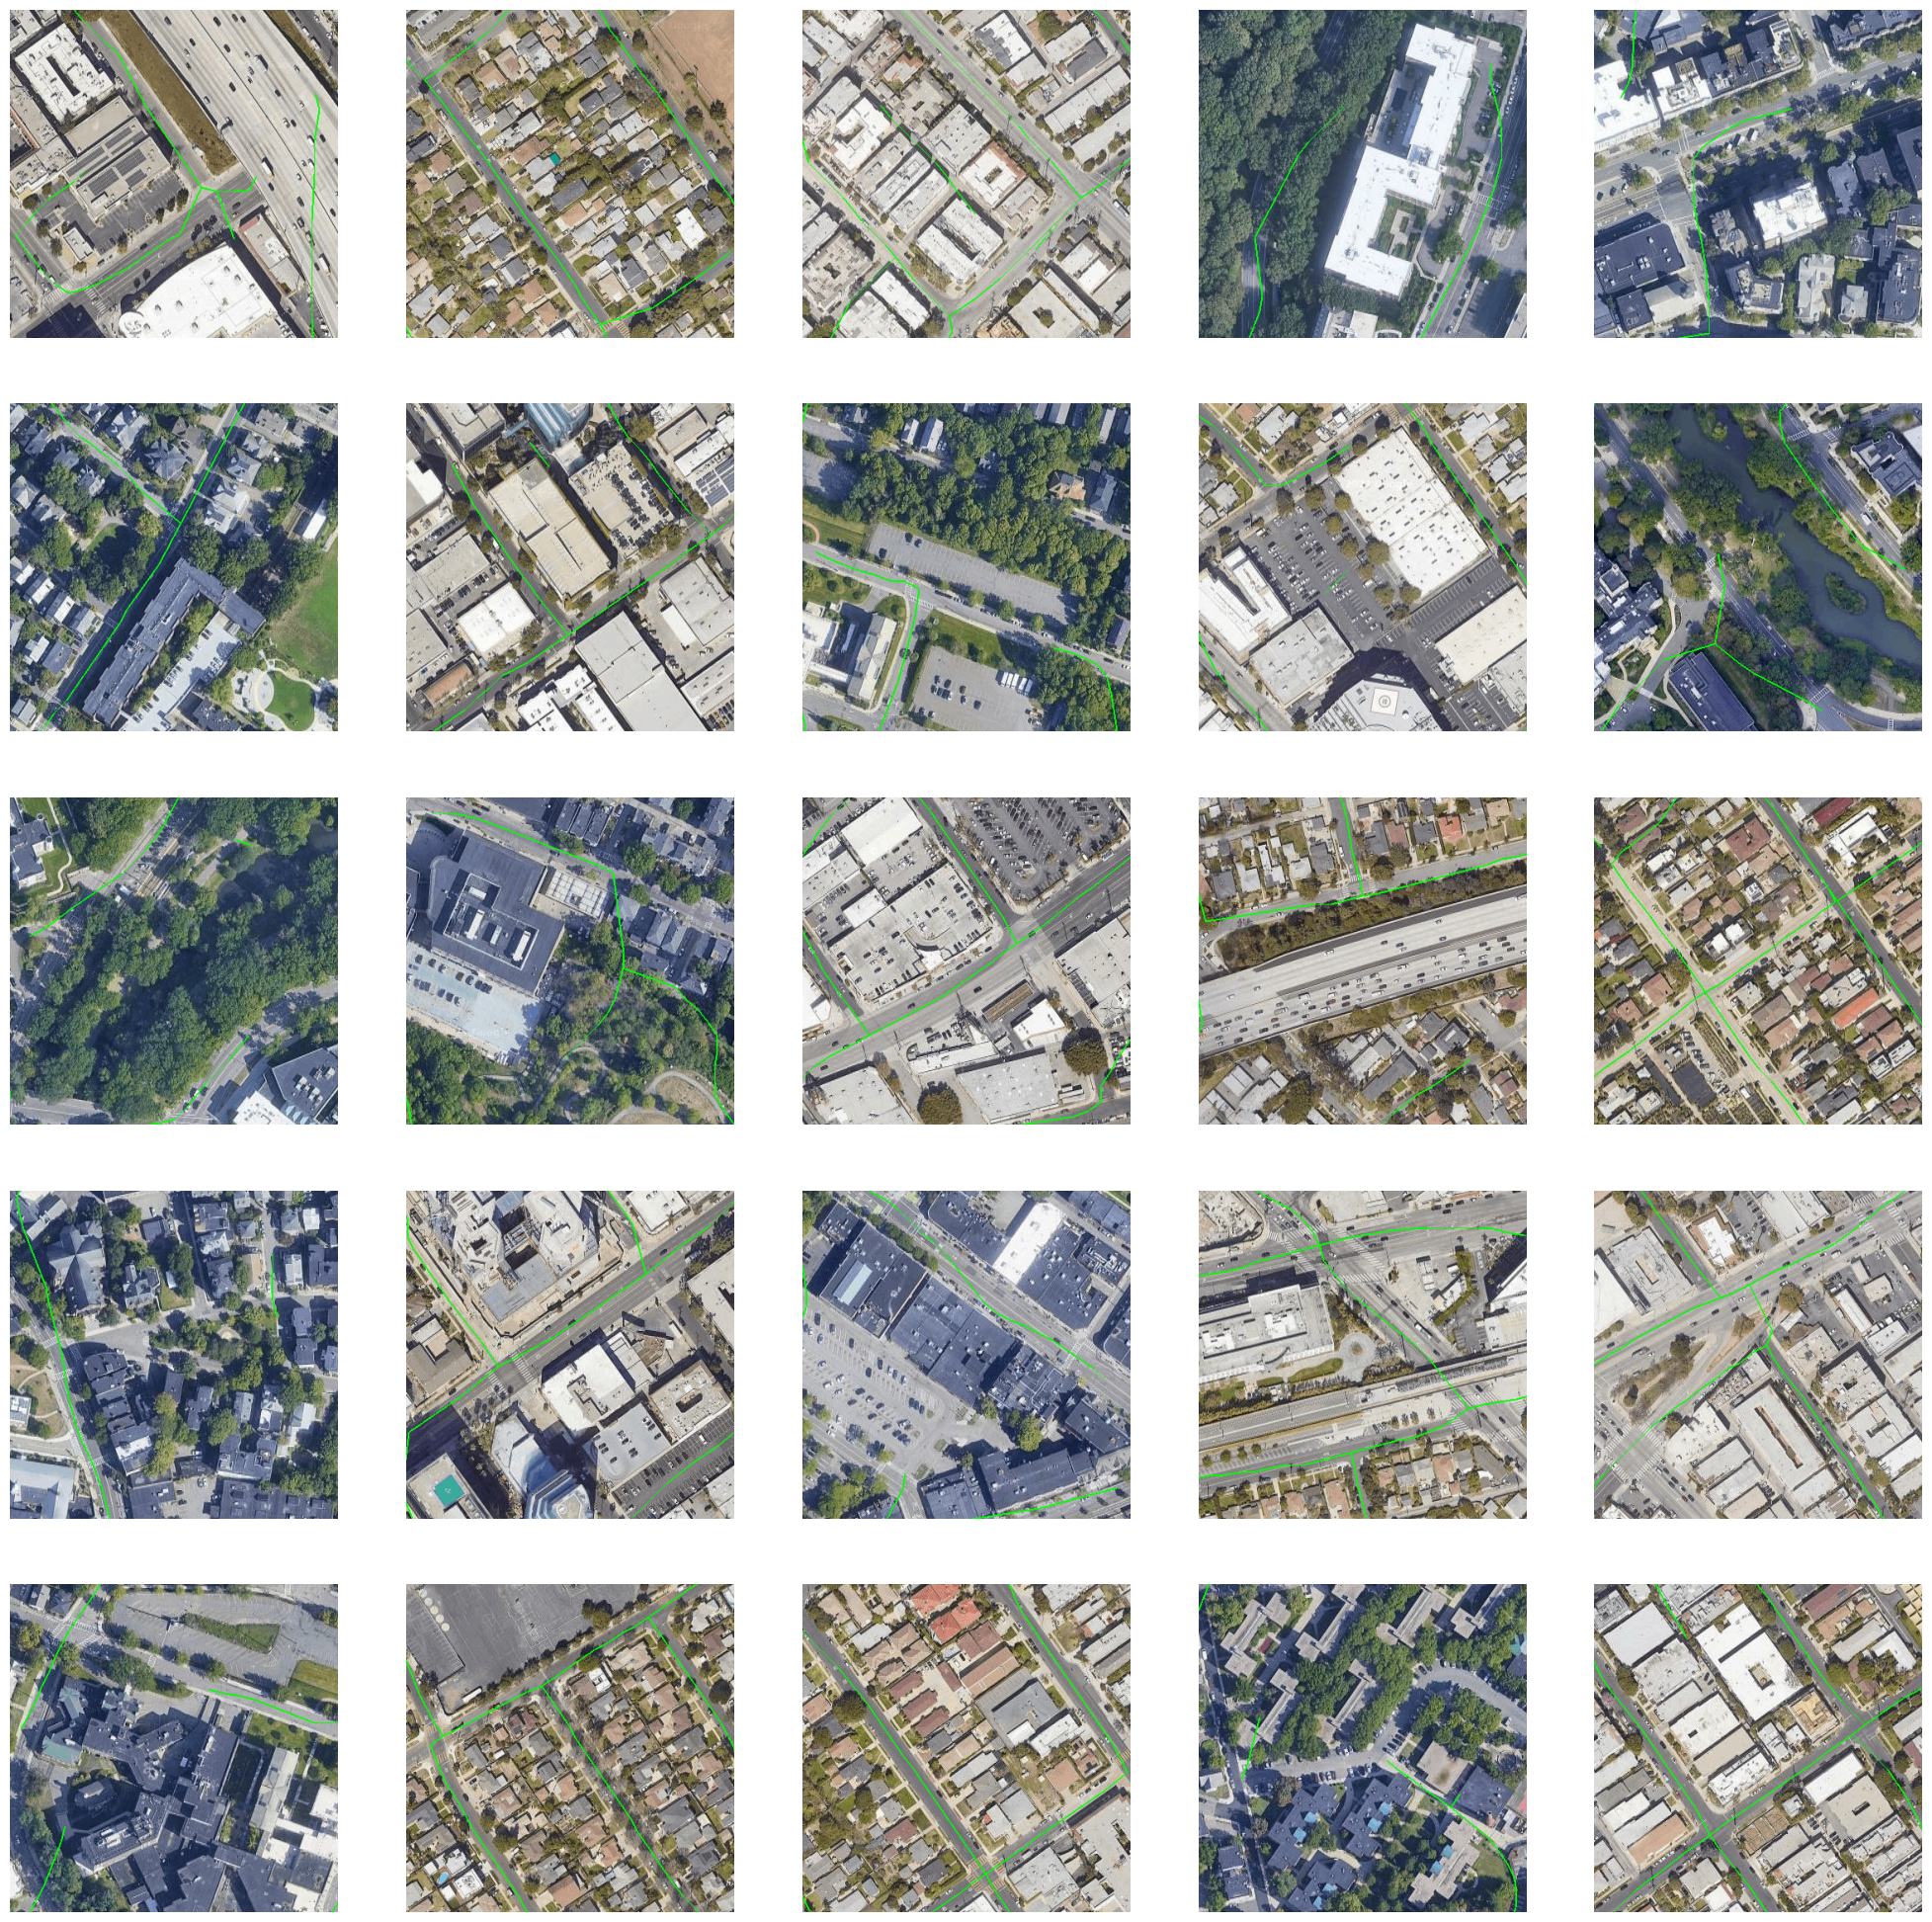

In [16]:
dim = (5,5)
fig, axs = plt.subplots(dim[0], dim[1], figsize=(5*dim[0], 5*dim[1]))

masks = load_all_from_path(parameters.ROOT_PATH + '/training/predictions/')
images = load_all_from_path(parameters.ROOT_PATH + '/training/images/')[:,:,:,:3]

for i in tqdm(range(dim[0] * dim[1])):
    starting_indices = get_starting_locations(masks[i])

    roadtracer_img = roadtracer_infer(roadtracer_model, session, images[i], starting_indices)[:,:,None] * np.array([0.0, 1.0, 0.0])

    roadtracer_img += (np.sum(roadtracer_img, axis=-1) == 0)[:,:,None] * images[i]
    # roadtracer_img += (np.sum(roadtracer_img, axis=-1) == 0)[:,:,None] * masks[i,:,:,None] 
    # roadtracer_img += (np.sum(roadtracer_img, axis=-1) == 0)[:,:,None] * masks[i,:,:,None]  * images[i]
    
    axs[i//dim[0], i%dim[0]].imshow(roadtracer_img)
    axs[i//dim[0], i%dim[0]].set_axis_off()


In [18]:
roadtracer_imgs = np.zeros((len(images), 400, 400))

for i in tqdm(range(len(images))):
    starting_indices = get_starting_locations(masks[i])
    roadtracer_imgs[i] = roadtracer_infer(roadtracer_model, session, images[i], starting_indices)
    im = Image.fromarray(roadtracer_imgs[i] * 255).convert('L')
    im.save(params.ROOT_PATH + f"/training/roadtracer/satimage_{i}.png")

  0%|          | 0/144 [00:00<?, ?it/s]

In [19]:
extra_folder_name = '/cil_data/**/'
extra_image_filenames = sorted(glob(parameters.ROOT_PATH + extra_folder_name + '/*.png'))

with torch.no_grad():
    for f in tqdm(extra_image_filenames):
        filename = Path(f).parts[-1].split('.')[0]

        # exclude masks (the dumb way)
        try:
            i = int(filename) - 1
        except:
            continue

        extra_image = np.array(Image.open(f), dtype=np.float32)[:, :, :3] / 255.0
        x = np_to_tensor(np.moveaxis(cv2.resize(extra_image, dsize=(384, 384)),-1,0), DEVICE)
        extra_mask_pred = np.moveaxis(model1(x.unsqueeze(0)).detach().cpu().numpy(),1,-1)
        extra_mask_pred = cv2.resize(extra_mask_pred[0], dsize=(400,400))

        starting_indices = get_starting_locations(extra_mask_pred)
        extra_roadtracer_img = roadtracer_infer(roadtracer_model, session, extra_image, starting_indices)
        im = Image.fromarray(extra_roadtracer_img * 255).convert('L')
        im.save(str(Path(f).parent) + f'/{i+1}_pred.png')

  0%|          | 0/13661 [00:00<?, ?it/s]

In [5]:
def get_extra_data(path):
    img_count = len(glob(path + '/*.png')) // 3
    
    images = np.stack([np.array(Image.open(path + f'/{i+1}.png'))[:,:,:3] for i in range(img_count)]).astype(np.float32) / 255.0
    graphs = np.stack([np.array(Image.open(path + f'/{i+1}_pred.png')) for i in range(img_count)]).astype(np.float32) / 255.0
    masks = np.stack([np.array(Image.open(path + f'/{i+1}_label.png'))[:,:,0] for i in range(img_count)]).astype(np.float32) / 255.0
    return images, graphs, masks

def get_all_extra_data(folders):
    folder_sizes = [len(glob(folder + '/*_label.png')) for folder in folders]
    images = np.stack([np.array(Image.open(folders[j] + f'/{i+1}.png'))[:,:,:3] for j in range(len(folders)) for i in range(folder_sizes[j])]).astype(np.float32) / 255.0
    graphs = np.stack([np.array(Image.open(folders[j] + f'/{i+1}_pred.png')) for j in range(len(folders)) for i in range(folder_sizes[j])]).astype(np.float32) / 255.0
    masks = np.stack([np.array(Image.open(folders[j] + f'/{i+1}_label.png'))[:,:,0] for j in range(len(folders)) for i in range(folder_sizes[j])]).astype(np.float32) / 255.0
    return images, graphs, masks

In [37]:
train_path = params.ROOT_PATH + f'/large_dataset/train/'
val_path = params.ROOT_PATH + f'/large_dataset/val/'

total_image_count = sum([len(glob(folder + '/*_label.png')) for folder in glob(params.ROOT_PATH + '/cil_data/*/')]) + len(load_all_from_path(parameters.ROOT_PATH + '/training/images'))
train_idx, val_idx = train_test_split(np.arange(total_image_count), test_size=0.2, random_state=42)
is_train = np.zeros((total_image_count), dtype=bool)

for i in train_idx:
    is_train[i] = True

images = load_all_from_path(parameters.ROOT_PATH + '/training/images')[:,:,:,:3] 
graphs = load_all_from_path(parameters.ROOT_PATH + '/training/roadtracer')
masks = load_all_from_path(parameters.ROOT_PATH + '/training/groundtruth')

img_index = 0

def save_images(img, graph, mask, index):
    if is_train[img_index]:
        save_path = train_path
    else:
        save_path = val_path

    img.save(save_path + f'/img/{index}.png')
    img.putalpha(graph)
    img.save(save_path + f'/img_with_graph/{index}.png')
    mask.save(save_path + f'/mask/{index}.png')


for i in tqdm(range(144)):
    img = Image.open(parameters.ROOT_PATH + f'/training/images/satimage_{i}.png')
    graph = Image.open(parameters.ROOT_PATH + f'/training/roadtracer/satimage_{i}.png')
    mask = Image.open(parameters.ROOT_PATH + f'/training/groundtruth/satimage_{i}.png')

    save_images(img, graph, mask, img_index)
    img_index += 1


for folder in glob(params.ROOT_PATH + '/cil_data/*/'):
    folder_size = len(glob(folder + '/*_label.png'))
    for i in tqdm(range(folder_size)):
        img = Image.open(folder + f'/{i+1}.png')
        graph = Image.open(folder + f'/{i+1}_pred.png')
        mask = Image.open(folder + f'/{i+1}_label.png').convert('L')

        save_images(img, graph, mask, img_index)
        img_index += 1

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/654 [00:00<?, ?it/s]

  0%|          | 0/587 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

  0%|          | 0/810 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/719 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
images = load_all_from_path(parameters.ROOT_PATH + '/training/images')[:, :, :, :3]
masks = load_all_from_path(parameters.ROOT_PATH + '/training/groundtruth')
graphs = load_all_from_path(parameters.ROOT_PATH + '/training/roadtracer')

# extra_folders = [params.ROOT_PATH + f'/cil_data/{i}_ZOOM_18' for i in range(6)]
# # extra_images, extra_graphs, extra_masks = get_extra_data(params.ROOT_PATH + '/cil_data/1_ZOOM_18')
# # extra_images, extra_graphs, extra_masks = get_all_extra_data(glob(params.ROOT_PATH + '/cil_data/*/')[:3])
# extra_images, extra_graphs, extra_masks = get_all_extra_data(extra_folders)

# images = np.concatenate([images, extra_images], axis=0)
# graphs = np.concatenate([graphs, extra_graphs], axis=0)
# masks = np.concatenate([masks, extra_masks], axis=0)

images_with_graphs = np.concatenate([images, graphs[:,:,:,None]], axis=-1)

train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

train_images_with_graph, val_images_with_graph, train_masks_with_graph, val_masks_with_graph = train_test_split(
    images_with_graphs, masks, test_size=0.2, random_state=42
)

assert np.array_equal(train_masks, train_masks_with_graph) and np.array_equal(val_masks, val_masks_with_graph)

train_ds = ImageDataset(train_images, train_masks, device=DEVICE, use_patches=False, resize_to=(384, 384))
val_ds = ImageDataset(val_images, val_masks, device=DEVICE, use_patches=False, resize_to=(384, 384))

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=4, shuffle=True)

train_ds_with_graph = ImageDataset(train_images_with_graph, train_masks_with_graph, device=DEVICE, use_patches=False, resize_to=(384, 384))
val_ds_with_graph = ImageDataset(val_images_with_graph, val_masks_with_graph, device=DEVICE, use_patches=False, resize_to=(384, 384))

train_dl_with_graph = torch.utils.data.DataLoader(train_ds_with_graph, batch_size=4, shuffle=True)
val_dl_with_graph = torch.utils.data.DataLoader(val_ds_with_graph, batch_size=4, shuffle=True)

In [ ]:
train_path = params.ROOT_PATH + f'/large_dataset/train/'
val_path = params.ROOT_PATH + f'/large_dataset/val/'

folders = glob(path + '/*/')
folder_sizes = [len(glob(folder + '/*_label.png')) for folder in folders]

for i in range(len(train_images)):
    print(train_images.shape)
    img = Image.fromarray(train_images[i] * 255)
    img_with_graph = Image.fromarray(train_images_with_graph[i] * 255)
    mask = Image.fromarray(train_masks[i] * 255).convert('L')

    img.save(train_path + f'/img/{i}.png')
    img_with_graph.save(train_path + f'/img_with_graph/{i}.png')
    mask.save(train_path + f'/mask/{i}.png')

for i in range(len(val_images)):
    img = Image.fromarray(val_images[i] * 255)
    img_with_graph = Image.fromarray(val_images_with_graph[i] * 255)
    mask = Image.fromarray(val_masks[i] * 255).convert('L')

    img.save(val_path + f'/img/{i}.png')
    img_with_graph.save(val_path + f'/img_with_graph/{i}.png')
    mask.save(val_path + f'/mask/{i}.png')

In [3]:
train_path = params.ROOT_PATH + f'/large_dataset/train/'
val_path = params.ROOT_PATH + f'/large_dataset/val/'

train_ds = LargeImageDataset(train_path + '/img/', train_path + '/mask/', DEVICE, (384, 384))
val_ds = LargeImageDataset(val_path + '/img/', val_path + '/mask/', DEVICE, (384, 384))

train_ds_with_graph = LargeImageDataset(train_path + '/img_with_graph/', train_path + '/mask/', DEVICE, (384, 384))
val_ds_with_graph = LargeImageDataset(val_path + '/img_with_graph/', val_path + '/mask/', DEVICE, (384, 384))

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=4, shuffle=True)

train_dl_with_graph = torch.utils.data.DataLoader(train_ds_with_graph, batch_size=4, shuffle=True)
val_dl_with_graph = torch.utils.data.DataLoader(val_ds_with_graph, batch_size=4, shuffle=True)

In [7]:
epochs = 100

model_graph = smp.ResUnet(
    encoder_name='efficientnet-b5',
    encoder_depth=5,
    encoder_weights=None,
    decoder_channels=(256, 128, 64, 32, 16),
    in_channels=4,
    classes=1,
).to(DEVICE)


loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer_graph = torch.optim.Adam(model_graph.parameters(), lr=1e-4)

metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}

wandb.init(
    name="with graph original data random initialization",
    project="CIL-2024",
    config={
        "learning_rate": optimizer_graph.param_groups[0]["lr"],
        "epochs": epochs,
        "n_training_examples": len(train_ds_with_graph),
        "n_validation_examples": len(val_ds_with_graph), 
        "parameter_count": sum([p.numel() for p in model_graph.parameters() if p.requires_grad]),
    },
    group="ResUNet"
)


train_smp_wandb(
    train_dataloader=train_dl_with_graph,
    eval_dataloader=val_dl_with_graph,
    model=model_graph,
    loss_fn=loss_fn,
    metric_fns=metric_fns,
    optimizer=optimizer_graph,
    n_epochs=epochs,
    val_freq=1,
    wandb_run=wandb
)

Epoch 1/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.7313990921809755
  	- val_loss = 0.6973937824368477
  	- f1_train = 0.25404528965210094
  	- f1_val = 0.28168667666614056
  	- acc = 0.44410195535626906
  	- val_acc = 0.17914348654448986
  	- patch_acc = 0.47219229463873236
  	- val_patch_acc = 0.2541232667863369
 


Epoch 2/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.7143287966991293
  	- val_loss = 0.692291334271431
  	- f1_train = 0.26834745191294573
  	- f1_val = 0.2858529258519411
  	- acc = 0.41528455039550516
  	- val_acc = 0.1824877019971609
  	- patch_acc = 0.4469438513805126
  	- val_patch_acc = 0.2604709230363369
 


Epoch 3/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.7020256971490795
  	- val_loss = 0.6840444803237915
  	- f1_train = 0.2800876025495858
  	- f1_val = 0.2937127985060215
  	- acc = 0.39863183477829245
  	- val_acc = 0.18840493448078632
  	- patch_acc = 0.43896172786581106
  	- val_patch_acc = 0.26860894076526165
 


Epoch 4/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.6876393392168242
  	- val_loss = 0.7021990045905113
  	- f1_train = 0.2931029128617254
  	- f1_val = 0.2766777705401182
  	- acc = 0.39794117623362046
  	- val_acc = 0.17619408573955297
  	- patch_acc = 0.4493684162353647
  	- val_patch_acc = 0.25151909701526165
 


Epoch 5/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.6778947320477716
  	- val_loss = 0.6835394576191902
  	- f1_train = 0.3016418542327552
  	- f1_val = 0.2949555478990078
  	- acc = 0.4160336975393624
  	- val_acc = 0.18932554498314857
  	- patch_acc = 0.4724267680069496
  	- val_patch_acc = 0.2690972238779068
 


Epoch 6/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.6684180724209753
  	- val_loss = 0.6925369128584862
  	- f1_train = 0.3112281124139654
  	- f1_val = 0.2856927700340748
  	- acc = 0.4463132527367822
  	- val_acc = 0.18248770013451576
  	- patch_acc = 0.5002344785065487
  	- val_patch_acc = 0.26047092117369175
 


Epoch 7/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.6536532188283986
  	- val_loss = 0.6943614408373833
  	- f1_train = 0.3253308195492317
  	- f1_val = 0.28412414342164993
  	- acc = 0.48962178723565464
  	- val_acc = 0.18096818029880524
  	- patch_acc = 0.5443007689097832
  	- val_patch_acc = 0.2575412355363369
 


Epoch 8/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.6318364205031559
  	- val_loss = 0.6828156188130379
  	- f1_train = 0.34732060802393944
  	- f1_val = 0.29536803998053074
  	- acc = 0.5593278377220549
  	- val_acc = 0.1898481622338295
  	- patch_acc = 0.6089409795300714
  	- val_patch_acc = 0.2692599818110466
 


Epoch 9/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.6088784275383785
  	- val_loss = 0.69408018887043
  	- f1_train = 0.3714797280985734
  	- f1_val = 0.2880460526794195
  	- acc = 0.6277759794531197
  	- val_acc = 0.18447685614228249
  	- patch_acc = 0.6671705472058264
  	- val_patch_acc = 0.26676432602107525
 


Epoch 10/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.5882448327952418
  	- val_loss = 0.6788664907217026
  	- f1_train = 0.3931854870812646
  	- f1_val = 0.29932139441370964
  	- acc = 0.6718619342507988
  	- val_acc = 0.1928051896393299
  	- patch_acc = 0.7029952961823036
  	- val_patch_acc = 0.27267795242369175
 


Epoch 11/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.5659303171881314
  	- val_loss = 0.6794655025005341
  	- f1_train = 0.4169776527018383
  	- f1_val = 0.3046142403036356
  	- acc = 0.7101854805288643
  	- val_acc = 0.2953694686293602
  	- patch_acc = 0.7325840181317823
  	- val_patch_acc = 0.4169379398226738
 


Epoch 12/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.5486859925862017
  	- val_loss = 0.6835139617323875
  	- f1_train = 0.433618760314481
  	- f1_val = 0.2933060619980097
  	- acc = 0.7239752987335468
  	- val_acc = 0.1884106546640396
  	- patch_acc = 0.7449413414659172
  	- val_patch_acc = 0.26860893703997135
 


Epoch 13/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.5229368579798731
  	- val_loss = 0.6892798021435738
  	- f1_train = 0.4611961738816623
  	- f1_val = 0.2887935061007738
  	- acc = 0.7560748766208517
  	- val_acc = 0.18420558609068394
  	- patch_acc = 0.7699652869125893
  	- val_patch_acc = 0.26242404989898205
 


Epoch 14/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.5112389243882278
  	- val_loss = 0.6720592305064201
  	- f1_train = 0.47440553944686364
  	- f1_val = 0.29736142605543137
  	- acc = 0.7760818765081209
  	- val_acc = 0.23039013147354126
  	- patch_acc = 0.784732202003742
  	- val_patch_acc = 0.3359917588531971
 


Epoch 15/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.4995562454749798
  	- val_loss = 0.665747843682766
  	- f1_train = 0.4843912350720373
  	- f1_val = 0.3058707993477583
  	- acc = 0.7786679350096604
  	- val_acc = 0.24560038559138775
  	- patch_acc = 0.7885785863317293
  	- val_patch_acc = 0.3375108540058136
 


Epoch 16/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.4741487379731803
  	- val_loss = 0.6825164929032326
  	- f1_train = 0.510317744879887
  	- f1_val = 0.3164912275969982
  	- acc = 0.7974712129296928
  	- val_acc = 0.628955639898777
  	- patch_acc = 0.8040389583028597
  	- val_patch_acc = 0.6424153819680214
 


Epoch 17/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.4587530719822851
  	- val_loss = 0.6774162501096725
  	- f1_train = 0.5282865516070662
  	- f1_val = 0.29747374542057514
  	- acc = 0.8142997026443481
  	- val_acc = 0.28083272092044353
  	- patch_acc = 0.8162266612052917
  	- val_patch_acc = 0.3562825508415699
 


Epoch 18/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.44614981782847435
  	- val_loss = 0.7206165343523026
  	- f1_train = 0.5399345673363785
  	- f1_val = 0.2787502594292164
  	- acc = 0.8204261763342495
  	- val_acc = 0.7250020727515221
  	- patch_acc = 0.8216295571162783
  	- val_patch_acc = 0.7060546949505806
 


Epoch 19/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.42740194961942474
  	- val_loss = 0.608144998550415
  	- f1_train = 0.5591407634060959
  	- f1_val = 0.375047042965889
  	- acc = 0.8299346278453695
  	- val_acc = 0.6796906813979149
  	- patch_acc = 0.8300506924760753
  	- val_patch_acc = 0.7040473148226738
 


Epoch 20/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.4207805970619465
  	- val_loss = 0.6263065114617348
  	- f1_train = 0.5644047126687807
  	- f1_val = 0.3675307258963585
  	- acc = 0.8321255404373695
  	- val_acc = 0.7445180714130402
  	- patch_acc = 0.8329891110288685
  	- val_patch_acc = 0.734537772834301
 


Epoch 21/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.4132525900314594
  	- val_loss = 0.5631827712059021
  	- f1_train = 0.573768767817267
  	- f1_val = 0.42302242293953896
  	- acc = 0.8390374409741369
  	- val_acc = 0.7400006204843521
  	- patch_acc = 0.8378133054437309
  	- val_patch_acc = 0.744791679084301
 


Epoch 22/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.3936376325015364
  	- val_loss = 0.5589242577552795
  	- f1_train = 0.5936273819413679
  	- f1_val = 0.4115418493747711
  	- acc = 0.8486938168262613
  	- val_acc = 0.6212777122855186
  	- patch_acc = 0.8453963213953478
  	- val_patch_acc = 0.6734483614563942
 


Epoch 23/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.3900438053854581
  	- val_loss = 0.5541941598057747
  	- f1_train = 0.5972222798857195
  	- f1_val = 0.4365980625152588
  	- acc = 0.850934127281452
  	- val_acc = 0.7726052552461624
  	- patch_acc = 0.8491529102983146
  	- val_patch_acc = 0.7560221403837204
 


Epoch 24/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.3662630422361966
  	- val_loss = 0.5574782863259315
  	- f1_train = 0.6206977490721077
  	- f1_val = 0.4239733964204788
  	- acc = 0.8603494866140957
  	- val_acc = 0.7229029461741447
  	- patch_acc = 0.8575341331547705
  	- val_patch_acc = 0.7303059995174408
 


Epoch 25/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.3600723414585508
  	- val_loss = 0.5442411154508591
  	- f1_train = 0.6274701665187704
  	- f1_val = 0.44419557601213455
  	- acc = 0.8646959991290651
  	- val_acc = 0.7675414681434631
  	- patch_acc = 0.8594498428805121
  	- val_patch_acc = 0.7603624165058136
 


Epoch 26/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.3454629799415325
  	- val_loss = 0.5169115737080574
  	- f1_train = 0.6427334526489521
  	- f1_val = 0.4686698354780674
  	- acc = 0.8708479794962652
  	- val_acc = 0.7688838094472885
  	- patch_acc = 0.8656609243360059
  	- val_patch_acc = 0.7709418460726738
 


Epoch 27/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.3397128725874013
  	- val_loss = 0.4930383488535881
  	- f1_train = 0.6495517533400963
  	- f1_val = 0.49011166021227837
  	- acc = 0.8757075400188051
  	- val_acc = 0.7616388574242592
  	- patch_acc = 0.8687939068366741
  	- val_patch_acc = 0.7632921040058136
 


Epoch 28/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.3276815291108756
  	- val_loss = 0.5436463505029678
  	- f1_train = 0.6618555332052296
  	- f1_val = 0.45254901982843876
  	- acc = 0.8798488296311477
  	- val_acc = 0.816101498901844
  	- patch_acc = 0.8710089469778126
  	- val_patch_acc = 0.7898763120174408
 


Epoch 29/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.3211915472458149
  	- val_loss = 0.49698425084352493
  	- f1_train = 0.6668557596617731
  	- f1_val = 0.48905719444155693
  	- acc = 0.8824190682378309
  	- val_acc = 0.7811756208539009
  	- patch_acc = 0.8761075200705692
  	- val_patch_acc = 0.7696397677063942
 


Epoch 30/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.32345064138544016
  	- val_loss = 0.4892001450061798
  	- f1_train = 0.6657324823839911
  	- f1_val = 0.5009664483368397
  	- acc = 0.8819677357015938
  	- val_acc = 0.813005231320858
  	- patch_acc = 0.87374282088773
  	- val_patch_acc = 0.7958984449505806
 


Epoch 31/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.30717949620608626
  	- val_loss = 0.49165501445531845
  	- f1_train = 0.682345371821831
  	- f1_val = 0.4976881295442581
  	- acc = 0.8901634442395178
  	- val_acc = 0.8128301948308945
  	- patch_acc = 0.8803829530189777
  	- val_patch_acc = 0.8003472313284874
 


Epoch 32/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.31556110340973426
  	- val_loss = 0.4821421727538109
  	- f1_train = 0.6732326067727188
  	- f1_val = 0.5106877833604813
  	- acc = 0.8848459350651708
  	- val_acc = 0.8219432830810547
  	- patch_acc = 0.8767311326388655
  	- val_patch_acc = 0.7978515699505806
 


Epoch 33/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.2840390678109794
  	- val_loss = 0.4677833095192909
  	- f1_train = 0.7062941296347256
  	- f1_val = 0.5256490334868431
  	- acc = 0.8984115123748779
  	- val_acc = 0.8187703043222427
  	- patch_acc = 0.8851572542354978
  	- val_patch_acc = 0.7964952439069748
 


Epoch 34/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.2962244934049146
  	- val_loss = 0.49344877898693085
  	- f1_train = 0.6922812893472868
  	- f1_val = 0.49557431042194366
  	- acc = 0.8926833066447027
  	- val_acc = 0.7971748858690262
  	- patch_acc = 0.8837703651395338
  	- val_patch_acc = 0.786892369389534
 


Epoch 35/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.27268675689039557
  	- val_loss = 0.4948866069316864
  	- f1_train = 0.7189180069956286
  	- f1_val = 0.49673496559262276
  	- acc = 0.903538348345921
  	- val_acc = 0.8096262738108635
  	- patch_acc = 0.8897369935594756
  	- val_patch_acc = 0.7922634556889534
 


Epoch 36/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.2645233520146074
  	- val_loss = 0.483344130218029
  	- f1_train = 0.7273418327857708
  	- f1_val = 0.5048575513064861
  	- acc = 0.907118963784185
  	- val_acc = 0.810215637087822
  	- patch_acc = 0.8920468174178025
  	- val_patch_acc = 0.7988281399011612
 


Epoch 37/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.2650310356041481
  	- val_loss = 0.4960748925805092
  	- f1_train = 0.7235103455083124
  	- f1_val = 0.49611230194568634
  	- acc = 0.9043846192031071
  	- val_acc = 0.8150204718112946
  	- patch_acc = 0.8952097399481411
  	- val_patch_acc = 0.798122838139534
 


Epoch 38/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.2608211061050152
  	- val_loss = 0.5077878162264824
  	- f1_train = 0.7287793015611583
  	- f1_val = 0.48679282143712044
  	- acc = 0.9066473389494007
  	- val_acc = 0.8266201019287109
  	- patch_acc = 0.895439219885859
  	- val_patch_acc = 0.8062065914273262
 


Epoch 39/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.25031330462159784
  	- val_loss = 0.46439604461193085
  	- f1_train = 0.7416472147250998
  	- f1_val = 0.5258125141263008
  	- acc = 0.9112352667183712
  	- val_acc = 0.8036475852131844
  	- patch_acc = 0.8944115248219721
  	- val_patch_acc = 0.7934027835726738
 


Epoch 40/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.27112671219069384
  	- val_loss = 0.5035680457949638
  	- f1_train = 0.7197780835217443
  	- f1_val = 0.49054769799113274
  	- acc = 0.9040056138203062
  	- val_acc = 0.8159883320331573
  	- patch_acc = 0.8895873345177749
  	- val_patch_acc = 0.7936740443110466
 


Epoch 41/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.24261600806795316
  	- val_loss = 0.47038307785987854
  	- f1_train = 0.7493432678025345
  	- f1_val = 0.5216146036982536
  	- acc = 0.9138561528304527
  	- val_acc = 0.8036776706576347
  	- patch_acc = 0.896905936043838
  	- val_patch_acc = 0.7868381217122078
 


Epoch 42/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.239796480228161
  	- val_loss = 0.4877466708421707
  	- f1_train = 0.7495838876428276
  	- f1_val = 0.509689848870039
  	- acc = 0.9134835498086338
  	- val_acc = 0.8227757439017296
  	- patch_acc = 0.9015056326471526
  	- val_patch_acc = 0.7969292551279068
 


Epoch 43/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.23776273480777083
  	- val_loss = 0.4679870530962944
  	- f1_train = 0.7544159889221191
  	- f1_val = 0.5264773070812225
  	- acc = 0.917148232460022
  	- val_acc = 0.82511967420578
  	- patch_acc = 0.8995450221259018
  	- val_patch_acc = 0.8040364608168602
 


Epoch 44/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.23019922807298857
  	- val_loss = 0.4811021164059639
  	- f1_train = 0.7600442335523409
  	- f1_val = 0.5065568052232265
  	- acc = 0.9192066480373514
  	- val_acc = 0.7964498698711395
  	- patch_acc = 0.9025632636300449
  	- val_patch_acc = 0.7839626744389534
 


Epoch 45/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.23053490704503551
  	- val_loss = 0.49037209898233414
  	- f1_train = 0.7625096501975224
  	- f1_val = 0.507471363991499
  	- acc = 0.9205624975007156
  	- val_acc = 0.8248662054538727
  	- patch_acc = 0.9016952103581922
  	- val_patch_acc = 0.795030377805233
 


Epoch 46/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.21943586859209785
  	- val_loss = 0.4691174849867821
  	- f1_train = 0.7714486677071144
  	- f1_val = 0.5316702537238598
  	- acc = 0.9227137894466005
  	- val_acc = 0.848168283700943
  	- patch_acc = 0.9046885021801653
  	- val_patch_acc = 0.8131510466337204
 


Epoch 47/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.24567880096106692
  	- val_loss = 0.5129543468356133
  	- f1_train = 0.7466939050575783
  	- f1_val = 0.4732924997806549
  	- acc = 0.9141335631239003
  	- val_acc = 0.774006113409996
  	- patch_acc = 0.8950301449874352
  	- val_patch_acc = 0.7663845643401146
 


Epoch 48/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.2124508023262024
  	- val_loss = 0.510993979871273
  	- f1_train = 0.7774816340413587
  	- f1_val = 0.486009880900383
  	- acc = 0.924141760530143
  	- val_acc = 0.8301005959510803
  	- patch_acc = 0.9079312435511885
  	- val_patch_acc = 0.8079427257180214
 


Epoch 49/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.2191994971242444
  	- val_loss = 0.4862959086894989
  	- f1_train = 0.7731065955655329
  	- f1_val = 0.5152135454118252
  	- acc = 0.9238807312373457
  	- val_acc = 0.843485102057457
  	- patch_acc = 0.9044540318949469
  	- val_patch_acc = 0.8054470494389534
 


Epoch 50/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.20900929796284642
  	- val_loss = 0.45489197969436646
  	- f1_train = 0.7853167283123937
  	- f1_val = 0.5398857519030571
  	- acc = 0.9281155795886599
  	- val_acc = 0.8299418538808823
  	- patch_acc = 0.9030920801491573
  	- val_patch_acc = 0.806532122194767
 


Epoch 51/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.21844604097563644
  	- val_loss = 0.4624353349208832
  	- f1_train = 0.772218854262911
  	- f1_val = 0.5288795307278633
  	- acc = 0.9233387379810728
  	- val_acc = 0.8133214339613914
  	- patch_acc = 0.9060255021884523
  	- val_patch_acc = 0.800184465944767
 


Epoch 52/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.20453079815568595
  	- val_loss = 0.48688550293445587
  	- f1_train = 0.7875224804056102
  	- f1_val = 0.5053594596683979
  	- acc = 0.9279615056925806
  	- val_acc = 0.8085583671927452
  	- patch_acc = 0.9073126336623882
  	- val_patch_acc = 0.7889540046453476
 


Epoch 53/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.19442909955978394
  	- val_loss = 0.4423687383532524
  	- f1_train = 0.7997923472831989
  	- f1_val = 0.5486678183078766
  	- acc = 0.9334021724503616
  	- val_acc = 0.8343707248568535
  	- patch_acc = 0.9081108364565619
  	- val_patch_acc = 0.8147244080901146
 


Epoch 54/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.20607667750325695
  	- val_loss = 0.4369732290506363
  	- f1_train = 0.7856621516161951
  	- f1_val = 0.5627774111926556
  	- acc = 0.9288441764897314
  	- val_acc = 0.8565815836191177
  	- patch_acc = 0.9090786699591011
  	- val_patch_acc = 0.8241102546453476
 


Epoch 55/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.1837026908479888
  	- val_loss = 0.48890411853790283
  	- f1_train = 0.8088595476643793
  	- f1_val = 0.508529793471098
  	- acc = 0.9365496923183573
  	- val_acc = 0.8321128413081169
  	- patch_acc = 0.9144266926009079
  	- val_patch_acc = 0.805447056889534
 


Epoch 56/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.19230625341678487
  	- val_loss = 0.46603480726480484
  	- f1_train = 0.7999061551587335
  	- f1_val = 0.5325978770852089
  	- acc = 0.9334442553849056
  	- val_acc = 0.8371306657791138
  	- patch_acc = 0.9123563314306324
  	- val_patch_acc = 0.8070204108953476
 


Epoch 57/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.1959260393833292
  	- val_loss = 0.44734442979097366
  	- f1_train = 0.7961219528625751
  	- f1_val = 0.5504023432731628
  	- acc = 0.9323193841967089
  	- val_acc = 0.8477999418973923
  	- patch_acc = 0.9083403287262752
  	- val_patch_acc = 0.8199869841337204
 


Epoch 58/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.19241166525873646
  	- val_loss = 0.46014586836099625
  	- f1_train = 0.8005369983870407
  	- f1_val = 0.5422102697193623
  	- acc = 0.9333491695338282
  	- val_acc = 0.8540702536702156
  	- patch_acc = 0.9090587147350969
  	- val_patch_acc = 0.8170030564069748
 


Epoch 59/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.18598766573544206
  	- val_loss = 0.46570873260498047
  	- f1_train = 0.8066465114725048
  	- f1_val = 0.5331483893096447
  	- acc = 0.9351432385115788
  	- val_acc = 0.8488742038607597
  	- patch_acc = 0.9120470223755672
  	- val_patch_acc = 0.8154296875
 


Epoch 60/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.18164373060752606
  	- val_loss = 0.48599668592214584
  	- f1_train = 0.8096097522768481
  	- f1_val = 0.5206694193184376
  	- acc = 0.9368582984496807
  	- val_acc = 0.8467659428715706
  	- patch_acc = 0.9157337608008549
  	- val_patch_acc = 0.8012695387005806
 


Epoch 61/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.1680765727470661
  	- val_loss = 0.4881623685359955
  	- f1_train = 0.8244065107970402
  	- f1_val = 0.5145089477300644
  	- acc = 0.9416407346725464
  	- val_acc = 0.8420948535203934
  	- patch_acc = 0.9163224512133105
  	- val_patch_acc = 0.8077799677848816
 


Epoch 62/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.18028242012550091
  	- val_loss = 0.45737914741039276
  	- f1_train = 0.8124456385086323
  	- f1_val = 0.5399246662855148
  	- acc = 0.9374396739334896
  	- val_acc = 0.8411371484398842
  	- patch_acc = 0.9126656343197
  	- val_patch_acc = 0.8139105960726738
 


Epoch 63/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.18201103703729038
  	- val_loss = 0.47527558356523514
  	- f1_train = 0.8117898188788315
  	- f1_val = 0.5164019204676151
  	- acc = 0.937503944183218
  	- val_acc = 0.8254375457763672
  	- patch_acc = 0.9112787370024056
  	- val_patch_acc = 0.803493931889534
 


Epoch 64/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.17442518678204766
  	- val_loss = 0.45668763667345047
  	- f1_train = 0.8176270291723055
  	- f1_val = 0.5387806184589863
  	- acc = 0.9388916739102068
  	- val_acc = 0.8379616290330887
  	- patch_acc = 0.9160081497554121
  	- val_patch_acc = 0.8113606870174408
 


Epoch 65/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.17634688985758815
  	- val_loss = 0.48158787190914154
  	- f1_train = 0.8161054664644701
  	- f1_val = 0.5147151947021484
  	- acc = 0.9393830340484093
  	- val_acc = 0.8309858217835426
  	- patch_acc = 0.9137083045367537
  	- val_patch_acc = 0.8002929762005806
 


Epoch 66/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.17180021055813494
  	- val_loss = 0.4476727619767189
  	- f1_train = 0.8219634726129729
  	- f1_val = 0.5531708151102066
  	- acc = 0.9414300918579102
  	- val_acc = 0.8562403917312622
  	- patch_acc = 0.9150552872953743
  	- val_patch_acc = 0.8206922858953476
 


Epoch 67/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.1646842648243082
  	- val_loss = 0.4792611747980118
  	- f1_train = 0.8285668163463987
  	- f1_val = 0.5166734009981155
  	- acc = 0.943703318464345
  	- val_acc = 0.8317903056740761
  	- patch_acc = 0.9160430739665854
  	- val_patch_acc = 0.804307721555233
 


Epoch 68/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.1556878500971301
  	- val_loss = 0.472217358648777
  	- f1_train = 0.8371069657391516
  	- f1_val = 0.5255468748509884
  	- acc = 0.9467380046844482
  	- val_acc = 0.8250280991196632
  	- patch_acc = 0.9212214659000265
  	- val_patch_acc = 0.7999674454331398
 


Epoch 69/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.16234257714501743
  	- val_loss = 0.48774344474077225
  	- f1_train = 0.8315485839186043
  	- f1_val = 0.5170089416205883
  	- acc = 0.9448373872658302
  	- val_acc = 0.8485355377197266
  	- patch_acc = 0.9155391989083126
  	- val_patch_acc = 0.8087022602558136
 


Epoch 70/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.15808588677439198
  	- val_loss = 0.45495906472206116
  	- f1_train = 0.8346164534831869
  	- f1_val = 0.5459036901593208
  	- acc = 0.9455652175278499
  	- val_acc = 0.8455840274691582
  	- patch_acc = 0.9170508179171332
  	- val_patch_acc = 0.8108724132180214
 


Epoch 71/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.14886566277208
  	- val_loss = 0.44995616376399994
  	- f1_train = 0.8441422170606153
  	- f1_val = 0.5518399365246296
  	- acc = 0.9490380122743803
  	- val_acc = 0.8553144633769989
  	- patch_acc = 0.9197148413493715
  	- val_patch_acc = 0.8181966245174408
 


Epoch 72/100:   0%|          | 0/29 [00:00<?, ?it/s]

In [ ]:
epochs = 100

model_base = smp.ResUnet(
    encoder_name='efficientnet-b5',
    encoder_depth=5,
    encoder_weights=None,
    decoder_channels=(256, 128, 64, 32, 16),
    in_channels=3,
    classes=1,
).to(DEVICE)


loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer_base = torch.optim.Adam(model_base.parameters(), lr=1e-4)

metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}

wandb.init(
    name="without graph original data random initialization",
    project="CIL-2024",
    config={
        "learning_rate": optimizer_base.param_groups[0]["lr"],
        "epochs": epochs,
        "n_training_examples": len(train_ds),
        "n_validation_examples": len(val_ds), 
        "parameter_count": sum([p.numel() for p in model_base.parameters() if p.requires_grad]),
    },
    group="ResUNet"
)


train_smp_wandb(
    train_dataloader=train_dl,
    eval_dataloader=val_dl,
    model=model_base,
    loss_fn=loss_fn,
    metric_fns=metric_fns,
    optimizer=optimizer_base,
    n_epochs=epochs,
    val_freq=1,
    wandb_run=wandb
)

Epoch 1/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.5935428697487404
  	- val_loss = 0.4592914953827858
  	- f1_train = 0.3858810005516842
  	- f1_val = 0.5287088379263878
  	- acc = 0.6104415028259672
  	- val_acc = 0.8114085868000984
  	- patch_acc = 0.6508171784466711
  	- val_patch_acc = 0.8180881142616272
 


Epoch 2/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.4211098736730115
  	- val_loss = 0.4276976138353348
  	- f1_train = 0.5639011274124014
  	- f1_val = 0.5621397383511066
  	- acc = 0.8272517467367237
  	- val_acc = 0.8327978029847145
  	- patch_acc = 0.840676891392675
  	- val_patch_acc = 0.8315972313284874
 


Epoch 3/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.3614903010171035
  	- val_loss = 0.38730867207050323
  	- f1_train = 0.6252297635736137
  	- f1_val = 0.6027428284287453
  	- acc = 0.8618224756471042
  	- val_acc = 0.8544589206576347
  	- patch_acc = 0.8708542914226137
  	- val_patch_acc = 0.852213554084301
 


Epoch 4/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.3252208746712783
  	- val_loss = 0.41168447583913803
  	- f1_train = 0.6641116224486252
  	- f1_val = 0.5748062282800674
  	- acc = 0.8793335002044151
  	- val_acc = 0.8382646813988686
  	- patch_acc = 0.8841894248436237
  	- val_patch_acc = 0.8428276926279068
 


Epoch 5/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.3022833466529846
  	- val_loss = 0.3777918815612793
  	- f1_train = 0.6866695223183468
  	- f1_val = 0.6114256307482719
  	- acc = 0.8889513899540079
  	- val_acc = 0.8539871722459793
  	- patch_acc = 0.8937829383488359
  	- val_patch_acc = 0.8515625074505806
 


Epoch 6/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.28582829236984253
  	- val_loss = 0.3655211701989174
  	- f1_train = 0.7045518015993053
  	- f1_val = 0.623932309448719
  	- acc = 0.8962745974803793
  	- val_acc = 0.8526075258851051
  	- patch_acc = 0.8976841959460028
  	- val_patch_acc = 0.8472764939069748
 


Epoch 7/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.27389202652306394
  	- val_loss = 0.3490499407052994
  	- f1_train = 0.7171152336844082
  	- f1_val = 0.643063373863697
  	- acc = 0.9014528373192097
  	- val_acc = 0.8663359731435776
  	- patch_acc = 0.900403107034749
  	- val_patch_acc = 0.8540581688284874
 


Epoch 8/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.2624166279003538
  	- val_loss = 0.33487237989902496
  	- f1_train = 0.7281859332117541
  	- f1_val = 0.6533603444695473
  	- acc = 0.9055107646975024
  	- val_acc = 0.8720400184392929
  	- patch_acc = 0.9038453924244848
  	- val_patch_acc = 0.866753488779068
 


Epoch 9/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.25026003040116407
  	- val_loss = 0.33613669872283936
  	- f1_train = 0.7417524970810989
  	- f1_val = 0.6540881395339966
  	- acc = 0.9112293411945475
  	- val_acc = 0.8743712231516838
  	- patch_acc = 0.9056114348871954
  	- val_patch_acc = 0.8609483614563942
 


Epoch 10/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.2383529153363458
  	- val_loss = 0.31749946624040604
  	- f1_train = 0.7525678133142406
  	- f1_val = 0.670256681740284
  	- acc = 0.9150533162314316
  	- val_acc = 0.873753659427166
  	- patch_acc = 0.9094678019655162
  	- val_patch_acc = 0.8643120750784874
 


Epoch 11/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.23101603573766247
  	- val_loss = 0.31504184007644653
  	- f1_train = 0.7613012317953438
  	- f1_val = 0.6753210425376892
  	- acc = 0.9188445909269924
  	- val_acc = 0.8849968537688255
  	- patch_acc = 0.9104007092015497
  	- val_patch_acc = 0.8723415955901146
 


Epoch 12/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.21905576771703258
  	- val_loss = 0.2981480211019516
  	- f1_train = 0.772701333309042
  	- f1_val = 0.6920546293258667
  	- acc = 0.922315054926379
  	- val_acc = 0.8878780007362366
  	- patch_acc = 0.9126357107326902
  	- val_patch_acc = 0.873697929084301
 


Epoch 13/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.2102889007535474
  	- val_loss = 0.3066416233778
  	- f1_train = 0.7812358901418489
  	- f1_val = 0.6846189498901367
  	- acc = 0.9256022634177372
  	- val_acc = 0.8848171383142471
  	- patch_acc = 0.9158784438823832
  	- val_patch_acc = 0.8694661408662796
 


Epoch 14/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.20284977452508335
  	- val_loss = 0.280636228621006
  	- f1_train = 0.7888268478985491
  	- f1_val = 0.7159422561526299
  	- acc = 0.9280122128026239
  	- val_acc = 0.9040794521570206
  	- patch_acc = 0.9160530443849235
  	- val_patch_acc = 0.8734809085726738
 


Epoch 15/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.1954011732134326
  	- val_loss = 0.29599329829216003
  	- f1_train = 0.7987679756920913
  	- f1_val = 0.6911263689398766
  	- acc = 0.9322481936421888
  	- val_acc = 0.8871074244379997
  	- patch_acc = 0.9139178292504673
  	- val_patch_acc = 0.879177525639534
 


Epoch 16/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.18872570785982856
  	- val_loss = 0.28546736389398575
  	- f1_train = 0.8034708376588493
  	- f1_val = 0.7012676447629929
  	- acc = 0.9336996921177568
  	- val_acc = 0.8864345550537109
  	- patch_acc = 0.9189166344445328
  	- val_patch_acc = 0.8793945387005806
 


Epoch 17/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.1826700259899271
  	- val_loss = 0.28685588389635086
  	- f1_train = 0.8081636243853075
  	- f1_val = 0.7087843865156174
  	- acc = 0.9357857395862711
  	- val_acc = 0.9042669907212257
  	- patch_acc = 0.9220895335592073
  	- val_patch_acc = 0.876736119389534
 


Epoch 18/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.1744541936907275
  	- val_loss = 0.2843082547187805
  	- f1_train = 0.8187411098644651
  	- f1_val = 0.7123401314020157
  	- acc = 0.9395804692958963
  	- val_acc = 0.9003705009818077
  	- patch_acc = 0.9201987611836401
  	- val_patch_acc = 0.8682725802063942
 


Epoch 19/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.17121725041290808
  	- val_loss = 0.27705197036266327
  	- f1_train = 0.8215946472924331
  	- f1_val = 0.712347961962223
  	- acc = 0.9413965159449084
  	- val_acc = 0.8995783254504204
  	- patch_acc = 0.9197447772683769
  	- val_patch_acc = 0.8828125074505806
 


Epoch 20/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.15979695525662652
  	- val_loss = 0.26423653960227966
  	- f1_train = 0.8334409758962434
  	- f1_val = 0.7230021730065346
  	- acc = 0.9443582399138089
  	- val_acc = 0.8975791931152344
  	- patch_acc = 0.9221344281887186
  	- val_patch_acc = 0.8855251744389534
 


Epoch 21/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.1568444145136866
  	- val_loss = 0.2743360102176666
  	- f1_train = 0.8338807718507175
  	- f1_val = 0.7244177162647247
  	- acc = 0.944646091296755
  	- val_acc = 0.9016782939434052
  	- patch_acc = 0.9252624182865538
  	- val_patch_acc = 0.865397147834301
 


Epoch 22/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.15757610880095382
  	- val_loss = 0.2667698785662651
  	- f1_train = 0.8358547461443934
  	- f1_val = 0.7263879701495171
  	- acc = 0.9461729197666563
  	- val_acc = 0.9034735485911369
  	- patch_acc = 0.9206028601218914
  	- val_patch_acc = 0.878797747194767
 


Epoch 23/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.14542377406153187
  	- val_loss = 0.2619570344686508
  	- f1_train = 0.8474030330263335
  	- f1_val = 0.7258710041642189
  	- acc = 0.9496877830604027
  	- val_acc = 0.9030340015888214
  	- patch_acc = 0.9244941370240574
  	- val_patch_acc = 0.8878580778837204
 


Epoch 24/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.14351274021740618
  	- val_loss = 0.26749127358198166
  	- f1_train = 0.8490650386645876
  	- f1_val = 0.7282336801290512
  	- acc = 0.9505306215121828
  	- val_acc = 0.9090366438031197
  	- patch_acc = 0.9232818525412987
  	- val_patch_acc = 0.8788520097732544
 


Epoch 25/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.14040151546741353
  	- val_loss = 0.2831215262413025
  	- f1_train = 0.8526586273620869
  	- f1_val = 0.7033706828951836
  	- acc = 0.9518481821849428
  	- val_acc = 0.894954264163971
  	- patch_acc = 0.9241199781154764
  	- val_patch_acc = 0.880316860973835
 


Epoch 26/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.14068025145037422
  	- val_loss = 0.26726599782705307
  	- f1_train = 0.8519821536952051
  	- f1_val = 0.7285242527723312
  	- acc = 0.9518270554213688
  	- val_acc = 0.8999513015151024
  	- patch_acc = 0.9232519248436237
  	- val_patch_acc = 0.8681098222732544
 


Epoch 27/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.13335073405298695
  	- val_loss = 0.2789641246199608
  	- f1_train = 0.8591751908433849
  	- f1_val = 0.7205321788787842
  	- acc = 0.9543941308712137
  	- val_acc = 0.9087702482938766
  	- patch_acc = 0.9255417955332789
  	- val_patch_acc = 0.8794487938284874
 


Epoch 28/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.13144038874527503
  	- val_loss = 0.2479265034198761
  	- f1_train = 0.8611028831580589
  	- f1_val = 0.7450391575694084
  	- acc = 0.9548082084491335
  	- val_acc = 0.9119904935359955
  	- patch_acc = 0.9248283937059599
  	- val_patch_acc = 0.8857964426279068
 


Epoch 29/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.12782422633006654
  	- val_loss = 0.2577095180749893
  	- f1_train = 0.86393286030868
  	- f1_val = 0.7364040389657021
  	- acc = 0.9556797311223787
  	- val_acc = 0.9059674963355064
  	- patch_acc = 0.9263350120906172
  	- val_patch_acc = 0.8784722238779068
 


Epoch 30/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.12502399395252095
  	- val_loss = 0.24795819073915482
  	- f1_train = 0.8687218222124823
  	- f1_val = 0.7426723465323448
  	- acc = 0.9578399493776518
  	- val_acc = 0.9079045206308365
  	- patch_acc = 0.9259808125167057
  	- val_patch_acc = 0.884060338139534
 


Epoch 31/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.12166865324151926
  	- val_loss = 0.25734611600637436
  	- f1_train = 0.8707664054015587
  	- f1_val = 0.7360653355717659
  	- acc = 0.958254142054196
  	- val_acc = 0.905658096075058
  	- patch_acc = 0.925187583627372
  	- val_patch_acc = 0.880045585334301
 


Epoch 32/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.1188331308036015
  	- val_loss = 0.26090729236602783
  	- f1_train = 0.8736351173499535
  	- f1_val = 0.7360536456108093
  	- acc = 0.959097161375243
  	- val_acc = 0.9058471396565437
  	- patch_acc = 0.9269386612135788
  	- val_patch_acc = 0.8713107779622078
 


Epoch 33/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.11729071058076003
  	- val_loss = 0.2651232108473778
  	- f1_train = 0.8745173791359211
  	- f1_val = 0.7289629057049751
  	- acc = 0.9597823989802393
  	- val_acc = 0.906294085085392
  	- patch_acc = 0.9259309234290287
  	- val_patch_acc = 0.881618931889534
 


Epoch 34/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.11334067377550848
  	- val_loss = 0.2622954249382019
  	- f1_train = 0.8781222988819254
  	- f1_val = 0.7358067333698273
  	- acc = 0.9609066905646488
  	- val_acc = 0.9052064716815948
  	- patch_acc = 0.9283505061577106
  	- val_patch_acc = 0.8682725727558136
 


Epoch 35/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.11147557661451142
  	- val_loss = 0.2633763775229454
  	- f1_train = 0.8806344681772692
  	- f1_val = 0.7314703911542892
  	- acc = 0.9615898769477318
  	- val_acc = 0.9065685272216797
  	- patch_acc = 0.9262252696629228
  	- val_patch_acc = 0.8768446296453476
 


Epoch 36/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.11108919053242125
  	- val_loss = 0.27106450498104095
  	- f1_train = 0.8814260630772032
  	- f1_val = 0.7326303347945213
  	- acc = 0.9620701012940243
  	- val_acc = 0.9086615219712257
  	- patch_acc = 0.9257363594811538
  	- val_patch_acc = 0.8655599132180214
 


Epoch 37/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.10913624229102299
  	- val_loss = 0.25517264008522034
  	- f1_train = 0.8821974520025582
  	- f1_val = 0.7382373958826065
  	- acc = 0.962714057544182
  	- val_acc = 0.910069152712822
  	- patch_acc = 0.9279314423429554
  	- val_patch_acc = 0.8838975802063942
 


Epoch 38/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.10715340745860133
  	- val_loss = 0.25393112003803253
  	- f1_train = 0.8858580712614388
  	- f1_val = 0.7396486103534698
  	- acc = 0.9635931767266372
  	- val_acc = 0.9041977003216743
  	- patch_acc = 0.9256415675426352
  	- val_patch_acc = 0.878092460334301
 


Epoch 39/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.10710764136807673
  	- val_loss = 0.26947442442178726
  	- f1_train = 0.8847263023771089
  	- f1_val = 0.7270350828766823
  	- acc = 0.9637138268043255
  	- val_acc = 0.9068078026175499
  	- patch_acc = 0.927193099054797
  	- val_patch_acc = 0.8778211921453476
 


Epoch 40/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.10392372567078163
  	- val_loss = 0.2540430799126625
  	- f1_train = 0.8874330479523231
  	- f1_val = 0.7418984621763229
  	- acc = 0.9645587884146591
  	- val_acc = 0.9117090553045273
  	- patch_acc = 0.9284951789625759
  	- val_patch_acc = 0.8800455778837204
 


Epoch 41/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.10160223163407424
  	- val_loss = 0.24931665509939194
  	- f1_train = 0.8903782552686231
  	- f1_val = 0.7425726279616356
  	- acc = 0.9655495964247605
  	- val_acc = 0.9101520106196404
  	- patch_acc = 0.9280162535864731
  	- val_patch_acc = 0.8899197056889534
 


Epoch 42/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.10031726442534349
  	- val_loss = 0.2585334926843643
  	- f1_train = 0.8905888939725941
  	- f1_val = 0.7435200959444046
  	- acc = 0.9658862434584519
  	- val_acc = 0.9142977446317673
  	- patch_acc = 0.9278915298396143
  	- val_patch_acc = 0.8728298619389534
 


Epoch 43/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.1001537586080617
  	- val_loss = 0.24605469405651093
  	- f1_train = 0.8924200205967344
  	- f1_val = 0.7538215592503548
  	- acc = 0.9660768385591179
  	- val_acc = 0.9154949262738228
  	- patch_acc = 0.9259109599836941
  	- val_patch_acc = 0.8773871660232544
 


Epoch 44/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.09841004322315085
  	- val_loss = 0.24502278119325638
  	- f1_train = 0.8935820460319519
  	- f1_val = 0.7464335188269615
  	- acc = 0.9671333103344358
  	- val_acc = 0.9075378924608231
  	- patch_acc = 0.9270085075805927
  	- val_patch_acc = 0.886013463139534
 


Epoch 45/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.09584416192153404
  	- val_loss = 0.25720760971307755
  	- f1_train = 0.895657884663549
  	- f1_val = 0.7374204397201538
  	- acc = 0.967416315243162
  	- val_acc = 0.9115556180477142
  	- patch_acc = 0.9282956226118679
  	- val_patch_acc = 0.8827040120959282
 


Epoch 46/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.0999697652356378
  	- val_loss = 0.25163470208644867
  	- f1_train = 0.890343189239502
  	- f1_val = 0.7469956278800964
  	- acc = 0.9671286015674986
  	- val_acc = 0.9151999279856682
  	- patch_acc = 0.9292684485172403
  	- val_patch_acc = 0.8782009556889534
 


Epoch 47/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.09601253476636164
  	- val_loss = 0.2508332058787346
  	- f1_train = 0.8965905822556595
  	- f1_val = 0.7445201948285103
  	- acc = 0.9673669749292834
  	- val_acc = 0.914803184568882
  	- patch_acc = 0.926070603831061
  	- val_patch_acc = 0.8828667551279068
 


Epoch 48/100:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 0.09080532912550301
  	- val_loss = 0.25749029964208603
  	- f1_train = 0.8991492452292607
  	- f1_val = 0.7449398562312126
  	- acc = 0.968977245791205
  	- val_acc = 0.9133603945374489
  	- patch_acc = 0.930455783317829
  	- val_patch_acc = 0.8707139790058136
 


Epoch 49/100:   0%|          | 0/29 [00:00<?, ?it/s]

KeyboardInterrupt: 

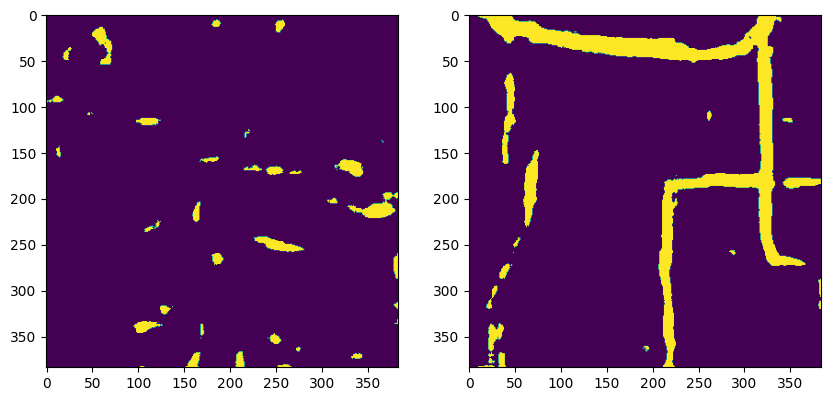

In [22]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].imshow(to_preds(model_base(val_ds[0][0].unsqueeze(0))).detach().cpu().numpy().squeeze())
axs[1].imshow(to_preds(model_graph(val_ds_with_graph[0][0].unsqueeze(0))).detach().cpu().numpy().squeeze())


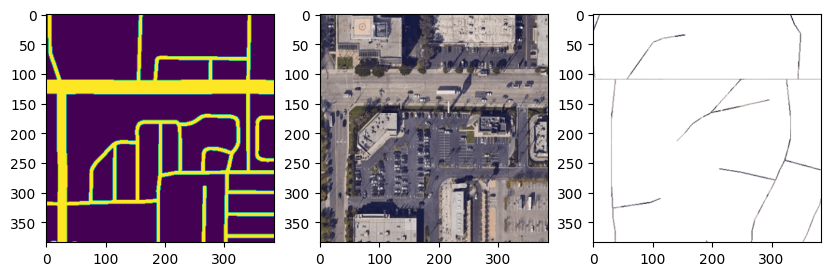

In [64]:
fig, axs = plt.subplots(1,3,figsize=(10,5))

i = 28

axs[0].imshow(np.moveaxis(val_ds[i][1].detach().cpu().numpy(), 0, -1))
axs[1].imshow(np.moveaxis(val_ds[i][0].detach().cpu().numpy(), 0, -1))
axs[2].imshow(np.moveaxis(val_ds_with_graph[i][0].detach().cpu().numpy(), 0, -1))

